In [30]:

import pyprob
import numpy as np
import ot
import torch
import cProfile
import pickle

from pyprob.dis import ModelDIS
from showerSim import invMass_ginkgo
from torch.utils.data import DataLoader
from pyprob.nn.dataset import OnlineDataset
from pyprob.util import InferenceEngine
from pyprob.util import to_tensor
from pyprob import Model
import math
from pyprob.distributions import Normal
from pyprob.distributions.delta import Delta


import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as mpl_cm
plt.ion()

from sbi import utils
from sbi import analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn


import sklearn as skl
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from joblib import Parallel, delayed
from torch.nn.functional import pad

from geomloss import SamplesLoss
sinkhorn = SamplesLoss(loss="sinkhorn", p=1, blur=.05)
def sinkhorn_t(x,y):
    x = torch.as_tensor(x)
    y = torch.as_tensor(y)
    return sinkhorn(x,y)

def ot_dist(x,y):
    x = x.detach().numpy()
    y = y.detach().numpy()
    a = ot.unif(len(x))
    b = ot.unif(len(y))
    Mat = ot.dist(x, y, metric='euclidean')
    distance = torch.tensor(ot.emd2(a,b,Mat))
    return distance

## Prepare functions


In [31]:
QCD_mass = to_tensor(30.)
#rate=to_tensor([QCD_rate,QCD_rate]) #Entries: [root node, every other node] decaying rates. Choose same values for a QCD jet
jetdir = to_tensor([1.,1.,1.])
jetP = to_tensor(400.)
jetvec = jetP * jetdir / torch.linalg.norm(jetdir) ## Jetvec is 3-momentum. JetP is relativistic p.


# Actual parameters
pt_min = to_tensor(0.3**2)
M2start = to_tensor(QCD_mass**2)
jetM = torch.sqrt(M2start) ## Mass of initial jet
jet4vec = torch.cat((torch.sqrt(jetP**2 + jetM**2).reshape(-1), jetvec))
minLeaves = 1
maxLeaves = 10000 # unachievable, to prevent rejections
maxNTry = 100


ginkgo_simulator = invMass_ginkgo.SimulatorModel(jet_p=jet4vec,  # parent particle 4-vector
                                    pt_cut=float(pt_min),  # minimum pT for resulting jet
                                    Delta_0= M2start,  # parent particle mass squared -> needs tensor
                                    M_hard=jetM,  # parent particle mass
                                    minLeaves=1,  # minimum number of jet constituents
                                    maxLeaves=10000,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
                                    suppress_output=True)

# Set maxLeaves to 50.
ginkgo_simulator_clip = invMass_ginkgo.SimulatorModel(jet_p=jet4vec,  # parent particle 4-vector
                                    pt_cut=float(pt_min),  # minimum pT for resulting jet
                                    Delta_0= M2start,  # parent particle mass squared -> needs tensor
                                    M_hard=jetM,  # parent particle mass
                                    minLeaves=1,  # minimum number of jet constituents
                                    maxLeaves=50,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
                                    suppress_output=True)


prior_min = [1e-3,1e-3]
prior_max = [30.,30.]
prior_full = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

In [3]:
def theta_grid(num_x, num_y):
    
    x_coords = torch.linspace(prior_min[0], prior_max[0], num_x+2)[1:-1]
    y_coords = torch.linspace(prior_min[1], prior_max[1], num_y+2)[1:-1]

    return torch.cartesian_prod(x_coords, y_coords)

def multi_ot_score(input, points_to_compare):
    """ This computes the optimal transport score of the input relative to the data points in 'points_to_compare'.

    Args:
        input: A tensor containing the leaves produced by ginkgo simulator.
        points_to_compare: A list of tensors containing leaves produced by ginkgo.

    Returns:
        Optimal tranpsort distances from the input to each point in points_to_compare 
    """
    distances = []
    for leaves in points_to_compare:
        distances.append(ot_dist(input,leaves))
    return torch.tensor(distances)


def create_points_from_thetas(thetas):
    data = []
    for theta in thetas:
        data.append(ginkgo_simulator(theta)['leaves'])
    return data

In [29]:
def flatten_data(leaves, sort = True):

    if sort:
        flattened = leaves[leaves[:, 0].sort()[1]].reshape(-1)
    else:
        flattened=leaves.reshape(-1)
    
    length = len(flattened)

    if length >= 200:
        return flattened[:200]
    else:
        pad_length = 200 - length
        return pad(flattened,(0,pad_length))
    
def make_summaries(leaves):
    min_leaf = leaves[leaves[:,0].argmin()]
    max_leaf = leaves[leaves[:,0].argmax()]
    num_leaf = torch.tensor([len(leaves)])
    energy_variance = torch.tensor([leaves[:,0].var()])

    return torch.cat([min_leaf, max_leaf, num_leaf, energy_variance])

In [5]:
def make_e_summaries(leaves):
    num_leaves = len(leaves)
    energies = leaves[:,0]
    e_mean = energies.mean()
    e_std = energies.std()
    
    def nthmoment(n):
        return torch.sum((energies - e_mean)**n/((num_leaves -1)*e_std**n))

    e_skewness = nthmoment(3)
    e_kurtosis = nthmoment(4)

    return torch.tensor([e_mean, e_std, e_skewness, e_kurtosis])

In [34]:
ref33=ginkgo_simulator([3,3])['leaves']
ref59 =ginkgo_simulator([5,9])['leaves']
ref1010 = ginkgo_simulator([10,10])['leaves']
ref153 = ginkgo_simulator([15,3])['leaves']
ref2525 = ginkgo_simulator([25,25])['leaves']

## Simulators

In [7]:
thetas = theta_grid(8,8)
data = create_points_from_thetas(thetas)

def get_ot_simulator(points_to_compare):
    """ Wrapper to generate simulator which takes parameters and calculates distances with the presimulated data in points_to_compare.

    Args:
        points_to_compare: points to calculate distances to.

    Returns:
        function: Returns function which runs the forward simulation and calculates summaries given a set of parameters.
    """
    def ot_simulator(params):
        input = ginkgo_simulator(params)['leaves']
        return multi_ot_score(input, points_to_compare)
        
    return ot_simulator

ot_simulator = get_ot_simulator(data)

In [34]:
ot_ref33 = multi_ot_score(ref33,data)
ot_ref59 = multi_ot_score(ref59,data)
ot_ref1010 = multi_ot_score(ref1010,data)
ot_ref153 = multi_ot_score(ref153,data)
ot_ref2525 = multi_ot_score(ref2525,data)


In [9]:
def flat_wrapper_sorted(params):   
    leaves = ginkgo_simulator(params)['leaves']
    return flatten_data(leaves, sort = True)

def flat_wrapper_unsorted(params):   
    leaves = ginkgo_simulator(params)['leaves']
    return flatten_data(leaves, sort = False)

In [35]:
flat_ref33 = flatten_data(ref33)
flat_ref59 = flatten_data(ref59)
flat_ref1010 = flatten_data(ref1010)
flat_ref153 = flatten_data(ref153)
flat_ref2525 = flatten_data(ref2525)

In [11]:
def summary_wrapper(params):
    return make_summaries(ginkgo_simulator(params)['leaves'])

In [36]:
sum_ref33 = make_summaries(ref33)
sum_ref59 = make_summaries(ref59)
sum_ref1010 = make_summaries(ref1010)
sum_ref153 = make_summaries(ref153)
sum_ref2525 = make_summaries(ref2525)

In [13]:
def e_summary_wrapper(params):
    return make_e_summaries(ginkgo_simulator(params)['leaves'])

In [37]:
esum_ref33 = make_e_summaries(ref33)
esum_ref59 = make_e_summaries(ref59)
esum_ref1010 = make_e_summaries(ref1010)
esum_ref153 = make_e_summaries(ref153)
esum_ref2525 = make_e_summaries(ref2525)

## Simulations

In [15]:
posterior_ot = infer(ot_simulator, prior_full, method='SNPE', num_simulations=5000,num_workers=7)

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 64 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

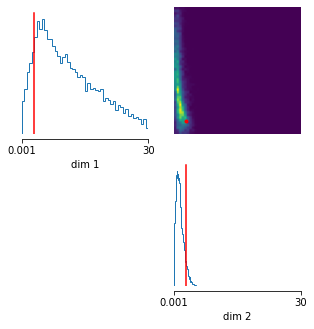

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

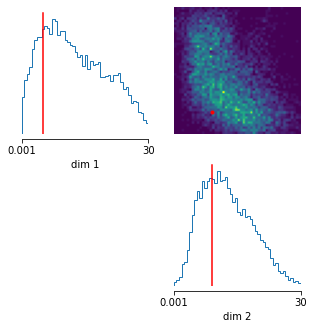

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

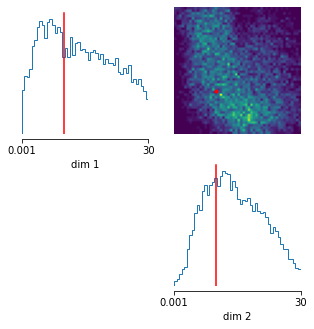

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

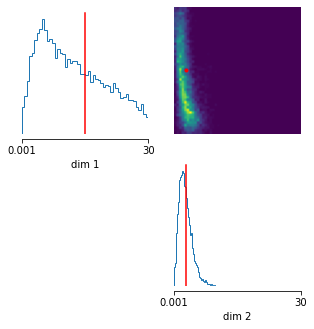

In [77]:
samples = posterior_ot.sample((10000,),x=ot_ref33)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([3,3]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()
samples = posterior_ot.sample((10000,),x=ot_ref59)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([5,9]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()
samples = posterior_ot.sample((10000,),x=ot_ref1010)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([10,10]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()
samples = posterior_ot.sample((10000,),x=ot_ref153)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([15,3]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

In [16]:
posterior_flat = infer(flat_wrapper_sorted, prior_full, method='SNPE', num_simulations=5000,num_workers=7)

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 46 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

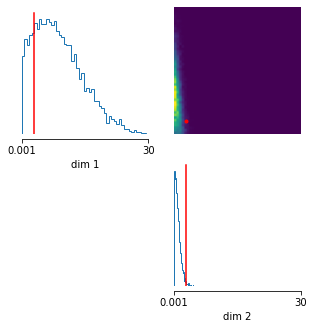

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

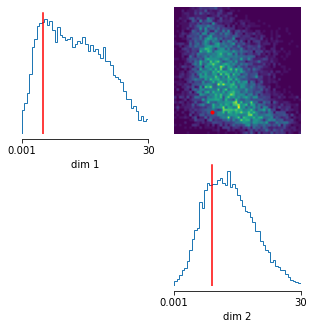

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

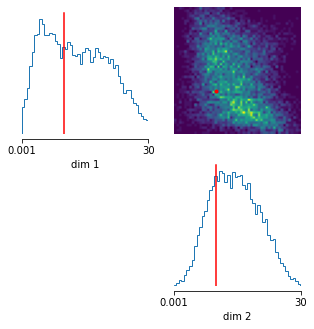

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

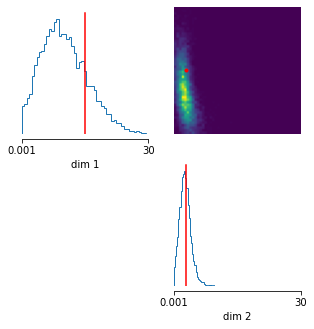

In [80]:
samples = posterior_flat.sample((10000,),x=flat_ref33)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([3,3]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()
samples = posterior_flat.sample((10000,),x=flat_ref59)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([5,9]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()
samples = posterior_flat.sample((10000,),x=flat_ref1010)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([10,10]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()
samples = posterior_flat.sample((10000,),x=flat_ref153)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([15,3]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

In [17]:
posterior_summaries = infer(summary_wrapper, prior_full, method='SNPE', num_simulations=5000,num_workers=7)

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 93 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

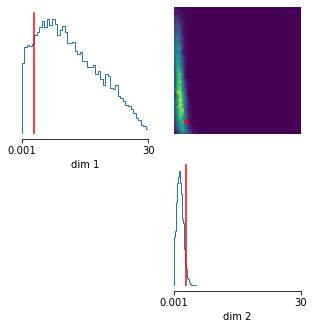

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

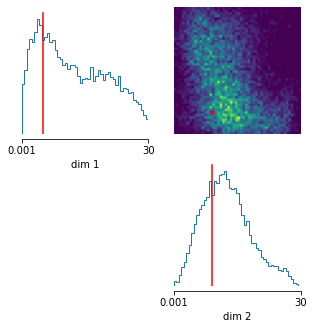

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

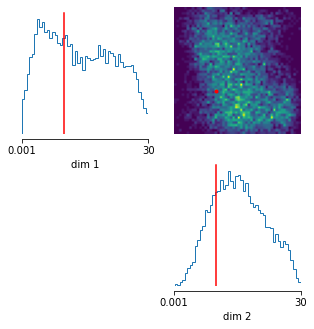

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

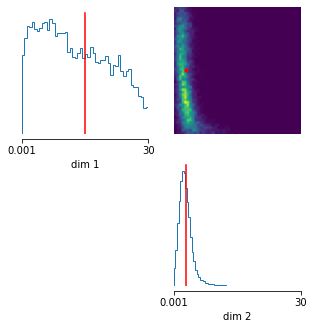

In [83]:
samples = posterior_summaries.sample((10000,),x=sum_ref33)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([3,3]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()
samples = posterior_summaries.sample((10000,),x=sum_ref59)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([5,9]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()
samples = posterior_summaries.sample((10000,),x=sum_ref1010)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([10,10]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()
samples = posterior_summaries.sample((10000,),x=sum_ref153)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([15,3]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

In [18]:
posterior_e_summaries = infer(e_summary_wrapper, prior_full, method='SNPE', num_simulations=5000,num_workers=7)

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 63 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

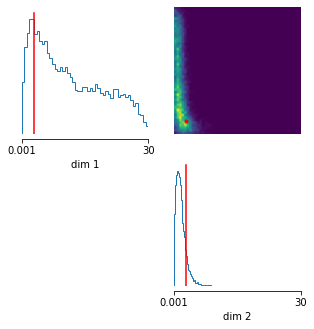

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

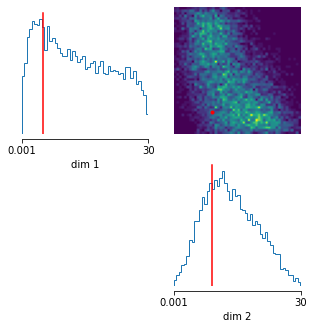

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

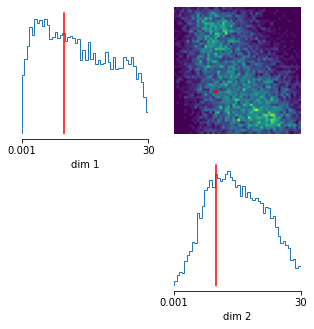

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

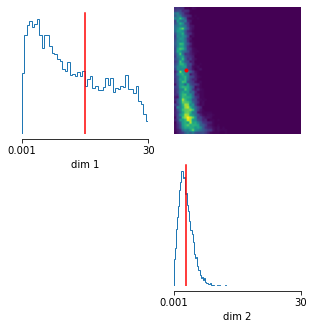

In [108]:
samples = posterior_e_summaries.sample((10000,),x=esum_ref33)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([3,3]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()
samples = posterior_e_summaries.sample((10000,),x=esum_ref59)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([5,9]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()
samples = posterior_e_summaries.sample((10000,),x=esum_ref1010)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([10,10]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()
samples = posterior_e_summaries.sample((10000,),x=esum_ref153)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([15,3]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

## Multi-round

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 61 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 40 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 52 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

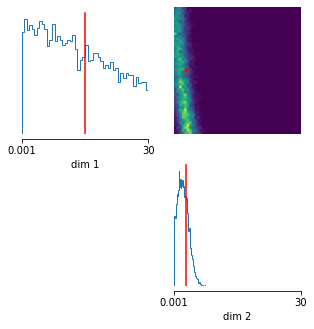

In [109]:
num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(ot_simulator, prior_full)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(ot_ref153)
    samples = posterior.sample((10000,))

fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([15,3]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 33 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

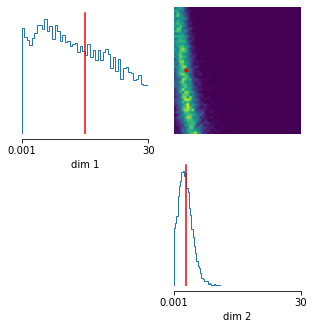

In [111]:
num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(flat_wrapper_sorted, prior_full)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(flat_ref153)
    samples = posterior.sample((10000,))

fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([15,3]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 112 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 36 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 71 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

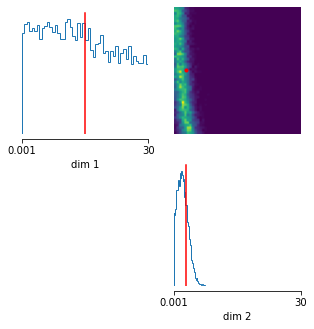

In [112]:
num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(summary_wrapper, prior_full)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(sum_ref153)
    samples = posterior.sample((10000,))

fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([15,3]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 88 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 38 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

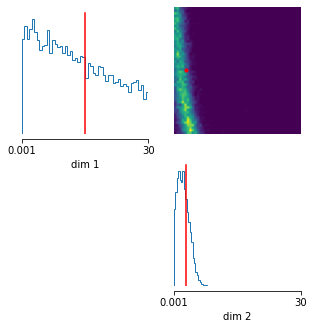

In [113]:
num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(e_summary_wrapper, prior_full)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(esum_ref153)
    samples = posterior.sample((10000,))

fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([15,3]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

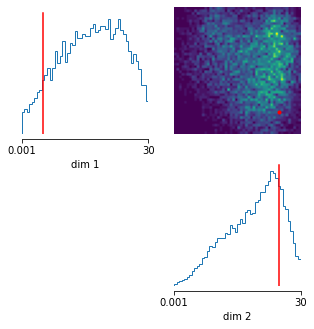

In [135]:
samples = posterior_ot.sample((10000,),x=multi_ot_score(ginkgo_simulator([5,25])['leaves'],data))
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([5,25]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');

plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

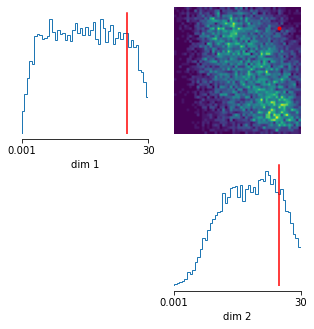

In [138]:
samples = posterior_e_summaries.sample((10000,),x=make_e_summaries(ginkgo_simulator([25,25])['leaves']))
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([25,25]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

## Just energy

In [85]:
def e_leaves(leaves):
    return leaves[:,0].reshape(-1,1)

def get_e_ot_simulator(points_to_compare):
    """ Wrapper to generate simulator which takes parameters and calculates distances with the presimulated data in points_to_compare.

    Args:
        points_to_compare: points to calculate distances to.

    Returns:
        function: Returns function which runs the forward simulation and calculates summaries given a set of parameters.
    """
    def ot_simulator(params):
        input = e_leaves(ginkgo_simulator(params)['leaves'])
        return multi_ot_score(input, points_to_compare)
        
    return ot_simulator

def e_flatten_data(leaves, sort = True):

    leaves = e_leaves(leaves)

    if sort:
        flattened = leaves[leaves[:, 0].sort()[1]].reshape(-1)
    else:
        flattened=leaves.reshape(-1)
    
    length = len(flattened)

    if length >= 100:
        return flattened[:100]
    else:
        pad_length = 100 - length
        return pad(flattened,(0,pad_length))

def e_full_simulator(params):
    leaves = ginkgo_simulator(params)['leaves']
    energy_leaves = e_leaves(leaves)
    return e_flatten_data(energy_leaves)


In [70]:
e_data = list(map(e_leaves,data))
e_ot_simulator = get_e_ot_simulator(e_data)

In [87]:
eot_ref33 = multi_ot_score(e_leaves(ref33),e_data)
eot_ref59 = multi_ot_score(e_leaves(ref59),e_data)
eot_ref1010 = multi_ot_score(e_leaves(ref1010),e_data)
eot_ref153 = multi_ot_score(e_leaves(ref153),e_data)

In [88]:
eflat_ref33 = e_flatten_data(ref33)
eflat_ref59 = e_flatten_data(ref59)
eflat_ref1010 = e_flatten_data(ref1010)
eflat_ref153 = e_flatten_data(ref153)

In [73]:
eot_posterior=infer(e_ot_simulator,prior_full,method='SNPE',num_simulations=5000,num_workers=7)

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.[pyKeOps]: Warning, no cuda detected. Switching to cpu only.[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.[pyKeOps]: Warning, no cuda detected. Switching to cpu only.

 Neural network successfully converged after 70 epochs.

In [89]:
eflat_posterior =infer(e_full_simulator,prior_full,method='SNPE',num_simulations=5000,num_workers=7)

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.[pyKeOps]: Warning, no cuda detected. Switching to cpu only.

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 46 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

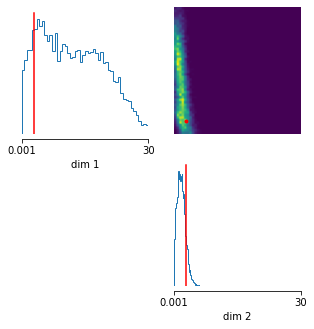

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

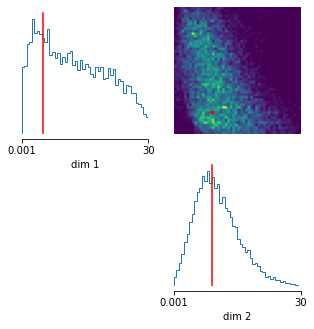

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

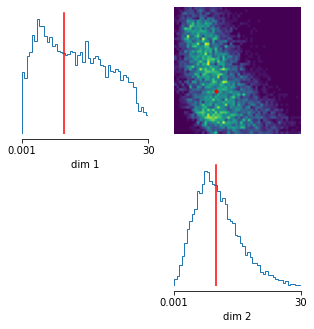

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

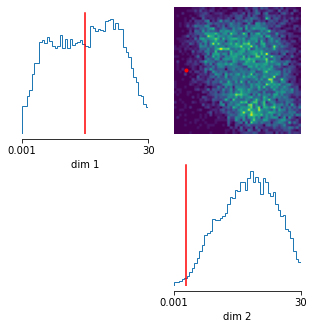

In [83]:
samples = eot_posterior.sample((10000,),x=eot_ref33)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([3,3]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');

plt.show()
samples = eot_posterior.sample((10000,),x=eot_ref59)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([5,9]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');

plt.show()
samples = eot_posterior.sample((10000,),x=eot_ref1010)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([10,10]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');

plt.show()
samples = eot_posterior.sample((10000,),x=eot_ref153)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([15,3]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');

plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

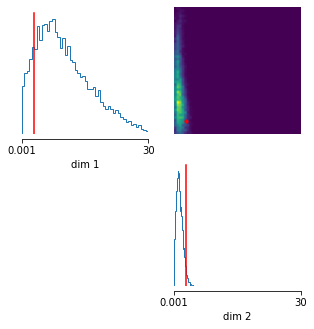

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

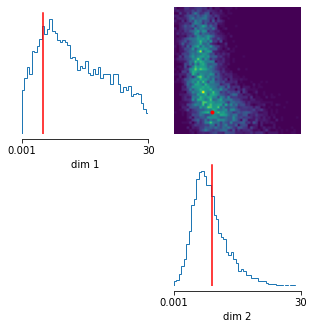

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

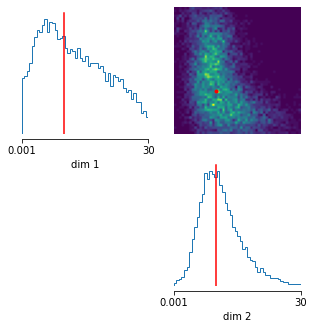

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

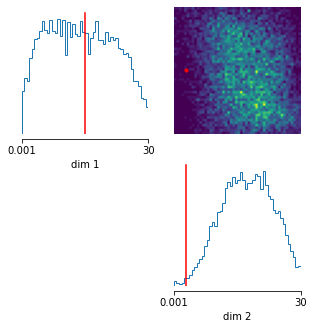

In [84]:
samples = eflat_posterior.sample((10000,),x=eflat_ref33)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([3,3]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');

plt.show()
samples = eflat_posterior.sample((10000,),x=eflat_ref59)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([5,9]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');

plt.show()
samples = eflat_posterior.sample((10000,),x=eflat_ref1010)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([10,10]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');

plt.show()
samples = eflat_posterior.sample((10000,),x=eflat_ref153)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([15,3]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');

plt.show()

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 75 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 51 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

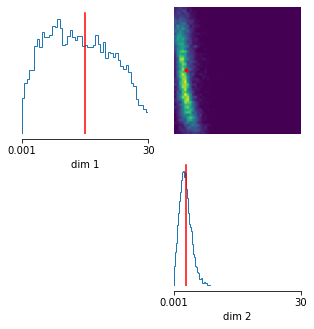

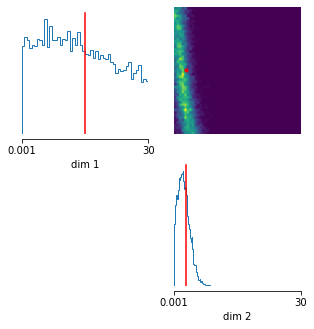

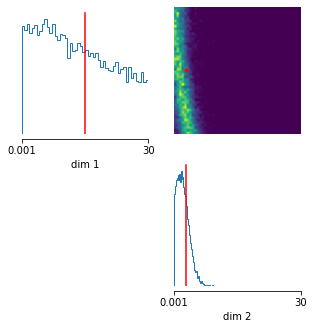

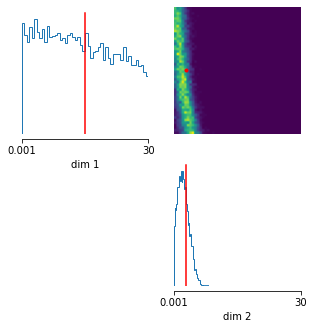

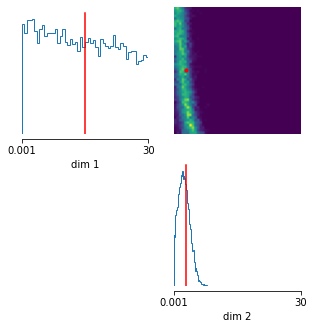

In [183]:
num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(e_summary_wrapper, prior_full)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(esum_ref153)
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[1e-3,30.], [1e-3,30.]],
                            ticks=[[1e-3,30.], [1e-3,30.]],
                            figsize=(5,5),
                            points=np.array([15,3]),
                            points_offdiag={'markersize': 6},
                            points_colors='r');
plt.show()

In [184]:
eot_ref2525 = e_ot_simulator([25,25])

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

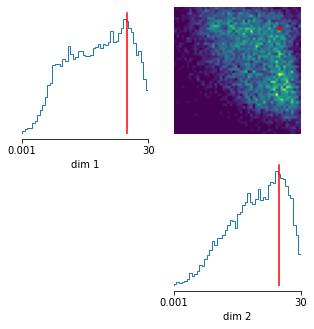

In [185]:
samples = eot_posterior.sample((10000,),x=eot_ref2525)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([25,25]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');

plt.show()

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.[pyKeOps]: Warning, no cuda detected. Switching to cpu only.

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 50 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 34 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

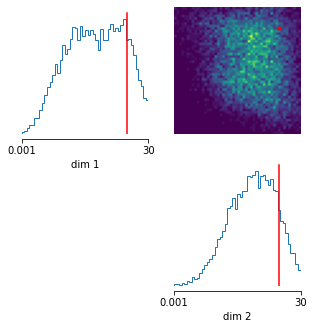

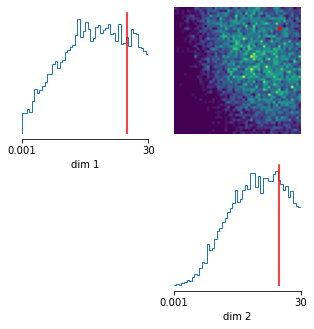

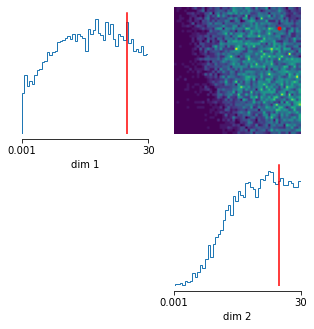

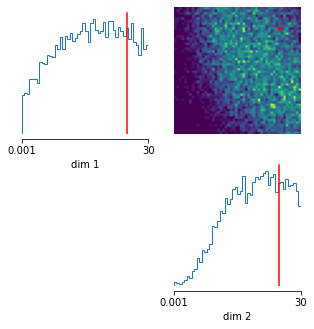

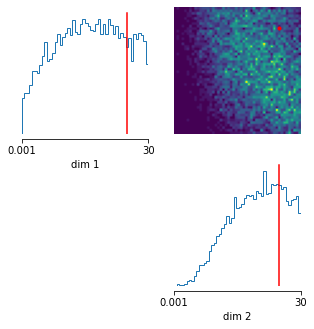

In [188]:
num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(e_ot_simulator, prior_full)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(eot_ref2525)
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[1e-3,30.], [1e-3,30.]],
                            ticks=[[1e-3,30.], [1e-3,30.]],
                            figsize=(5,5),
                            points=np.array([25,25]),
                            points_offdiag={'markersize': 6},
                            points_colors='r');
plt.show()

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


/home/sragy/anaconda3/envs/sbi/lib/python3.8/site-packages/ot/lp/__init__.py:495: UserWarning: Problem unbounded
  check_result(result_code)


 Neural network successfully converged after 82 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

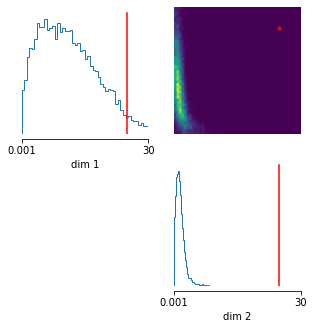

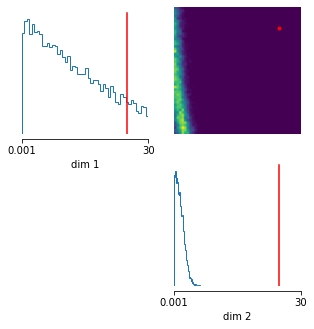

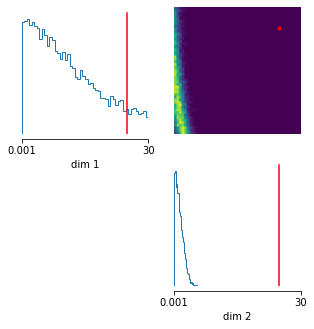

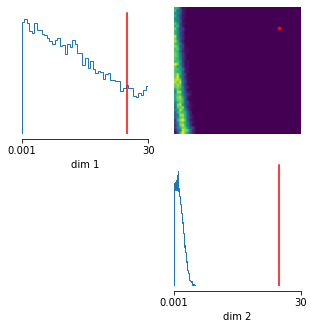

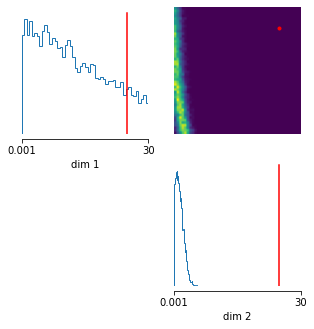

In [189]:
num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(e_ot_simulator, prior_full)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(eot_ref33)
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[1e-3,30.], [1e-3,30.]],
                            ticks=[[1e-3,30.], [1e-3,30.]],
                            figsize=(5,5),
                            points=np.array([3,3]),
                            points_offdiag={'markersize': 6},
                            points_colors='r');
plt.show()

# MSE

In [30]:
def MSE(samples, true_params):
    loss = torch.nn.MSELoss()
    return loss(samples, true_params)

In [51]:
def ot_summary_wrap(leaves):
    return multi_ot_score(leaves, data)

In [61]:
def MSE_list(posterior_list, summary_fn_list, param_list, mean = True):

    data_list = [ginkgo_simulator(param)['leaves'] for param in param_list]
    
    assert len(posterior_list) == len(summary_fn_list), "posteriors must be in 1-to-1 correspondence to the summaries"

    MSE_list = []
    for i in range(len(posterior_list)):
        posterior = posterior_list[i]
        summary_fn = summary_fn_list[i]  
        MSE_for_posterior = []
        for j in range(len(data_list)):
            summary = summary_fn(data_list[j])
            samples = posterior.sample((1000,),x=summary,show_progress_bars = False)
            MSE_for_posterior.append(MSE(samples, param_list[j]))

        if mean:
            MSE_list.append(torch.tensor(MSE_for_posterior).mean())
        else:
            MSE_list.append(MSE_for_posterior)

    return MSE_list

In [41]:
ot_samples33 = posterior_ot.sample((1000,), x=ot_ref33)
ot_samples59 = posterior_ot.sample((1000,), x=ot_ref59)
ot_samples1010 = posterior_ot.sample((1000,), x=ot_ref1010)
ot_samples153 = posterior_ot.sample((1000,), x=ot_ref153)
ot_samples2525 = posterior_ot.sample((1000,), x=ot_ref2525)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [43]:
MSE_ot_list = []
MSE_ot_list.append(MSE(ot_samples33, torch.tensor([3,3])))
MSE_ot_list.append(MSE(ot_samples59, torch.tensor([5,9])))
MSE_ot_list.append(MSE(ot_samples1010, torch.tensor([10,10])))
MSE_ot_list.append(MSE(ot_samples153, torch.tensor([15,3])))
MSE_ot_list.append(MSE(ot_samples2525, torch.tensor([25,25])))

In [44]:
MSE_ot_list[0]

tensor(70.8733)

In [90]:
posteriors = [posterior_ot, posterior_flat, posterior_summaries, posterior_e_summaries, eflat_posterior]
summary_fns = [ot_summary_wrap,flatten_data, make_summaries, make_e_summaries, e_flatten_data]
print(MSE_list(posteriors, summary_fns, [torch.tensor([3,3])]*50))
print(MSE_list(posteriors, summary_fns, [torch.tensor([5,9])]*50))
print(MSE_list(posteriors, summary_fns, [torch.tensor([10,10])]*50))
print(MSE_list(posteriors, summary_fns, [torch.tensor([15,3])]*50))
print(MSE_list(posteriors, summary_fns, [torch.tensor([25,25])]*50))

/home/sragy/anaconda3/envs/sbi/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1000, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[tensor(71.8443), tensor(69.4408), tensor(75.9338), tensor(70.2229), tensor(76.8245)]
[tensor(76.8591), tensor(75.8843), tensor(84.1294), tensor(79.7422), tensor(82.3026)]
[tensor(62.1338), tensor(62.5233), tensor(64.4678), tensor(64.7243), tensor(61.9975)]
[tensor(56.3337), tensor(49.6921), tensor(53.6607), tensor(57.4168), tensor(52.0472)]
[tensor(83.1825), tensor(80.9047), tensor(81.8758), tensor(91.4534), tensor(88.7856)]


In [95]:
new_thetas = theta_grid(14,14)
big_data = create_points_from_thetas(new_thetas)
big_ot_simulator = get_ot_simulator(big_data)

In [96]:
big_ot_posterior = infer(big_ot_simulator,prior_full,method='SNPE',num_simulations=5000,num_workers=7)

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 48 epochs.

In [98]:
def ot_summary_wrap_2(leaves):
    return multi_ot_score(leaves, big_data)

posteriors = [posterior_ot, posterior_flat, posterior_summaries, posterior_e_summaries, eflat_posterior,big_ot_posterior ]
summary_fns = [ot_summary_wrap,flatten_data, make_summaries, make_e_summaries, e_flatten_data,ot_summary_wrap_2]
print(MSE_list(posteriors, summary_fns, [torch.tensor([3,3])]*50))
print(MSE_list(posteriors, summary_fns, [torch.tensor([5,9])]*50))
print(MSE_list(posteriors, summary_fns, [torch.tensor([10,10])]*50))
print(MSE_list(posteriors, summary_fns, [torch.tensor([15,3])]*50))
print(MSE_list(posteriors, summary_fns, [torch.tensor([25,25])]*50))

[tensor(73.9287), tensor(68.9371), tensor(75.8271), tensor(72.3681), tensor(75.7309), tensor(68.7062)]
[tensor(83.1475), tensor(81.2720), tensor(91.2591), tensor(86.3170), tensor(86.8161), tensor(82.6583)]
[tensor(64.8789), tensor(67.3146), tensor(70.0394), tensor(68.3787), tensor(67.4624), tensor(64.2684)]
[tensor(49.4237), tensor(42.8716), tensor(47.4316), tensor(53.9880), tensor(44.2300), tensor(43.5489)]
[tensor(95.8034), tensor(87.8997), tensor(93.9411), tensor(99.9427), tensor(96.0140), tensor(91.0114)]


## Pyprob

In [57]:
from pyprob.distributions import Normal

In [85]:
class Pyprob_Ginkgo(invMass_ginkgo.SimulatorModel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def flatten_data(self, leaves, sort = True):
        
        if sort:
            flattened = leaves[leaves[:, 0].sort()[1]].reshape(-1)
        else:
            flattened=leaves.reshape(-1)
        
        length = len(flattened)

        if length >= 200:
            return flattened[:200]
        else:
            pad_length = 200 - length
            return pad(flattened,(0,pad_length))

            

    def forward(self, inputs=None):
        assert inputs is None # Modify code if this ever not met?
        # Sample parameter of interest from Unif(0,10) prior
        root_rate = pyprob.sample(pyprob.distributions.Uniform(0.001, 30.),
                                  name="decay_rate_parameter")
        decay_rate = pyprob.sample(pyprob.distributions.Uniform(0.001, 30.),
                                   name="decay_rate_parameter")
        # Simulator code needs two decay rates for (1) root note (2) all others
        # For now both are set to the same value
        inputs = [root_rate, decay_rate]
        jet = super().forward(inputs)
        leaves = jet['leaves']
        # flat_leaves = self.flatten_data(leaves)
        # delta = Delta(flat_leaves)
        # pyprob.observe(delta, name = 'obs')
        # std = torch.clamp(flat_leaves, min = 0.001)
        # centred_norm = Normal(flat_leaves, std)
        # pyprob.observe(centred_norm, name = 'obs')
        dist = ot_dist(leaves, ref33)
        centred_norm = Normal(dist, 0.01)
        pyprob.observe(centred_norm, name = 'obs')
        return [root_rate, decay_rate]

# Make instance of the simulator
pyprob_model = Pyprob_Ginkgo(jet_p=jet4vec,  # parent particle 4-vector
                                    pt_cut=float(pt_min),  # minimum pT for resulting jet
                                    Delta_0= M2start,  # parent particle mass squared -> needs tensor
                                    M_hard=jetM,  # parent particle mass
                                    minLeaves=1,  # minimum number of jet constituents
                                    maxLeaves=10000,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
                                    suppress_output=True)

In [86]:
pyprob_model.learn_inference_network(num_traces=5000,
                              observe_embeddings={'obs' : {'dim' : 32}},
                              inference_network=pyprob.InferenceNetwork.LSTM)

Creating new inference network...
Observable obs: reshape not specified, using shape torch.Size([]).
Observable obs: using embedding dim torch.Size([32]).
Observable obs: observe embedding not specified, using the default FEEDFORWARD.
Observable obs: embedding depth not specified, using the default 2.
Observe embedding dimension: 32
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
New layers, address: 32__forward__root_rate__Uniform__1, distribution: Uniform
New layers, address: 56__forward__decay_rate__Uniform__1, distribution: Uniform
Total addresses: 2, distribution types: 1, parameters: 1,718,518
0d:00:02:44 | 1    | 4,992     | +6.80e+00 | +6.65e+00 | +6.70e+00 | 0d:00:00:43 | +1.00e-03 | 20.3                               
Stop condition reached. num_traces: 5000
0d:00:02:47 | 1    | 5,056     | +6.80e+00 | +6.65e+00 | +6.74e+00 | 0d:00:00:47 | +1.00e-03 | 18.3                               


In [46]:
flat_ref33 = flatten_data(ref33)
flat_ref59 = flatten_data(ref59)
flat_ref1010 = flatten_data(ref1010)
flat_ref153 = flatten_data(ref153)
flat_ref2525 = flatten_data(ref2525)

In [90]:
posterior = pyprob_model.posterior_results(num_traces=10000, inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, observe={'obs':torch.tensor(0)})

Time spent  | Time remain.| Progress             | Trace       | ESS     | Traces/sec


KeyboardInterrupt: 

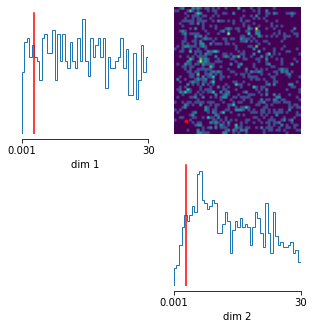

In [ ]:
samples = torch.tensor(posterior.values)
fig, axes = analysis.pairplot(samples,
                        limits=[[1e-3,30.], [1e-3,30.]],
                        ticks=[[1e-3,30.], [1e-3,30.]],
                        figsize=(5,5),
                        points=np.array([3,3]),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

# Roughs

In [16]:
leaves = ginkgo_simulator([3,3])['leaves']

In [24]:
leaves[leaves[:,0].argmax()]

tensor([149.3987,  92.3568,  80.4539,  85.5412])

In [21]:
leaves

tensor([[ 21.5386,  13.1205,  13.0521,  11.0179],
        [ 18.6992,  11.7062,  10.4556,  10.1633],
        [ 12.5492,   7.1650,   7.6739,   6.8732],
        [  9.4321,   5.7765,   5.3646,   5.1779],
        [149.3987,  92.3568,  80.4539,  85.5412],
        [  2.2659,   1.0327,   1.4618,   1.3598],
        [  1.2855,   0.5819,   0.7227,   0.8753],
        [  5.0463,   2.2623,   3.4688,   2.8821],
        [  7.6941,   3.3313,   5.6058,   4.0810],
        [  4.0620,   1.9503,   2.7362,   2.2678],
        [  0.8193,   0.4801,   0.5685,   0.3334],
        [  2.7132,   1.2915,   1.6421,   1.7229],
        [  2.4251,   1.1587,   1.6341,   1.3647],
        [  5.4282,   2.5032,   3.7059,   3.0687],
        [  1.7372,   0.8160,   1.1870,   0.9686],
        [ 20.6274,  11.0743,  12.3885,  12.2194],
        [  2.7610,   1.4245,   1.7109,   1.6331],
        [  3.8565,   2.0002,   2.4474,   2.2016],
        [  9.1065,   4.8402,   5.2226,   5.6763],
        [ 29.2792,  16.3380,  17.1663,  17.1945],


In [90]:
leaves[:,0].mean()

tensor(12.9395)

In [101]:
make_e_summaries(ref1010)

/tmp/ipykernel_1979/2611488386.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_mean = torch.tensor(energies.mean())
/tmp/ipykernel_1979/2611488386.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_std = torch.tensor(energies.std())


tensor([33.4269, 46.3002,  1.5588,  3.8680])

In [155]:
ot_dist(leaves[:,0].reshape(-1,1),leaves[:,0].reshape(-1,1))

tensor(0.)

In [153]:
leaves[:,0].reshape(-1,1)

tensor([[ 21.5386],
        [ 18.6992],
        [ 12.5492],
        [  9.4321],
        [149.3987],
        [  2.2659],
        [  1.2855],
        [  5.0463],
        [  7.6941],
        [  4.0620],
        [  0.8193],
        [  2.7132],
        [  2.4251],
        [  5.4282],
        [  1.7372],
        [ 20.6274],
        [  2.7610],
        [  3.8565],
        [  9.1065],
        [ 29.2792],
        [  4.2676],
        [  6.5223],
        [ 37.4276],
        [  9.1364],
        [ 12.5930],
        [  4.8564],
        [  4.2633],
        [  3.7632],
        [  5.6320],
        [  1.5087],
        [  0.4279]])